<img style="max-width:20em; height:auto;" src="../graphics/A-Little-Book-on-Adversarial-AI-Cover.png"/>

Author: Nik Alleyne   
Author Blog: https://www.securitynik.com   
Author GitHub: github.com/securitynik   

Author Other Books: [   

            "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/",   
            
            "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/"   
        ]   


This notebook ***(attacking_decision_trees.ipynb)*** is part of the series of notebooks From ***A Little Book on Adversarial AI***  A free ebook released by Nik Alleyne

### Attacking Decision Trees  

### Lab Objectives:   
- Learn about Decision Trees   
- Attack Decision Trees    
- Leverage ART for attacking Decision Trees  
- Perform targeted attack against Decision Trees  
- Perform untargeted attack attack Decision Trees 


### Step 1:   
Get the data   

In [1]:
# import the libraries
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

import art
from art.attacks.evasion import DecisionTreeAttack
from art.estimators.classification import SklearnClassifier

In [2]:
### Version of key libraries used  
print(f'ART version used:  {art.__version__}')
print(f'Numpy version used:  {np.__version__}')


ART version used:  1.20.1
Numpy version used:  2.1.3


In [3]:
# Load the file with the features and labels
X_y = np.load(r'../data/bodmas.npz', allow_pickle=False)

print(f'The files are: {X_y.files}')

X = X_y['X']
y = X_y['y']

# Get the firs 10 samples
X[:10], y[:10]

The files are: ['X', 'y']


(array([[0.05674198, 0.00801749, 0.00776239, ..., 0.        , 0.        ,
         0.        ],
        [0.00706228, 0.00449971, 0.00449817, ..., 0.        , 0.        ,
         0.        ],
        [0.0209748 , 0.00469876, 0.00400208, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.07330591, 0.00815132, 0.00499523, ..., 0.        , 0.        ,
         0.        ],
        [0.00796591, 0.00385708, 0.00368597, ..., 0.        , 0.        ,
         0.        ],
        [0.00595277, 0.00401828, 0.00393758, ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32))

In [4]:
# Get the shape of the data
X.shape, y.shape

((134435, 2381), (134435,))

In [5]:
# Get a view into the classes
np.unique(ar=y, return_counts=True)

(array([0, 1], dtype=int32), array([77142, 57293]))

In [6]:
# Setup some labels
class_labels = ['malware', 'benign']
class_labels

['malware', 'benign']

In [7]:
# prepare to split the data into train and test splits
from sklearn.model_selection import train_test_split

In [8]:
# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, test_size=.20, random_state=10, shuffle=True)

# Get the shapes of the various sets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((107548, 2381), (107548,), (26887, 2381), (26887,))

### Step 2:   
Prepare to build the Decision Tree  

In [9]:
# Prepare to build the decision tree
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [10]:
# Train the decision tree classifier
# Keep the tree to a depth of 5 for simplicity and to reduce overfitting
dt_clf = DecisionTreeClassifier(max_depth=5, criterion='gini', random_state=10)
dt_clf.fit(X=X_train, y=y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,10
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [11]:
# Print the classification report
print(metrics.classification_report(y_true=y_test, y_pred=dt_clf.predict(X=X_test)))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     15291
           1       0.92      0.96      0.94     11596

    accuracy                           0.95     26887
   macro avg       0.95      0.95      0.95     26887
weighted avg       0.95      0.95      0.95     26887



Note, the accuracy is being reported at 95. By any measure, this is a good accuracy. However, no need for us to worry about that. The objective here is not to build a model that can be deployed. It is instead to attack a model that has been deployed.    

### Step 3:   
Visualize the model   

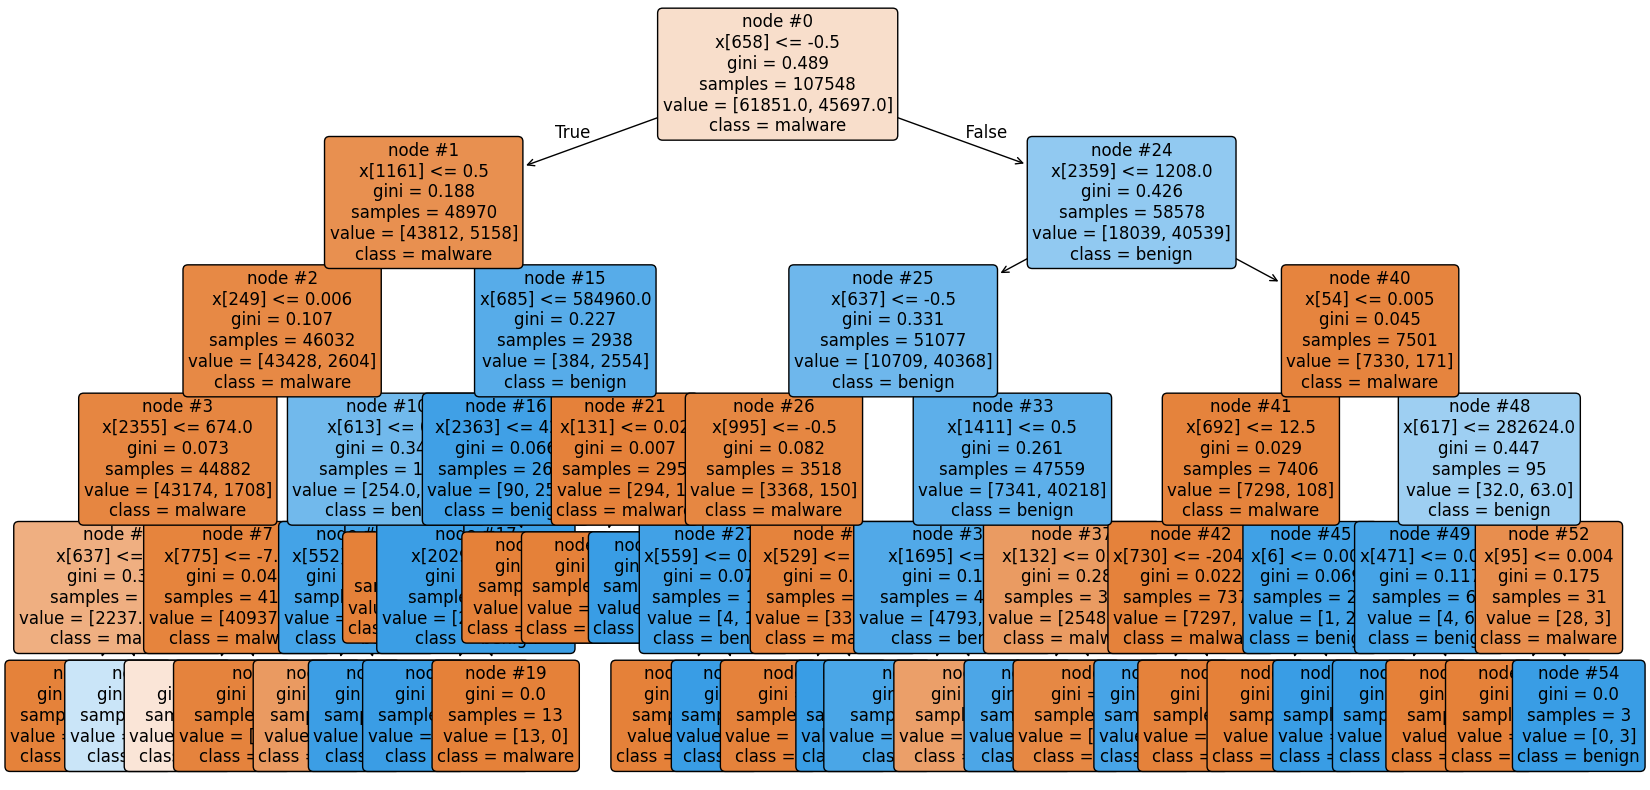

In [12]:
# Visualize the tree
plt.figure(figsize=(20,10))
plot_tree(decision_tree=dt_clf, filled=True, rounded=True,node_ids=True, fontsize=12, class_names=class_labels);

In [13]:
# Predict on the real test set
real_test_predictions = dt_clf.predict(X=X_test)
real_test_predictions[:10]

array([1, 0, 0, 1, 0, 1, 1, 0, 0, 0], dtype=int32)

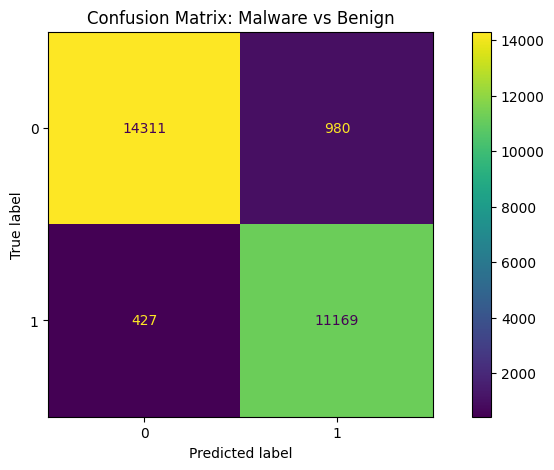

In [14]:
# Get the confusion matrix
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_title(label='Confusion Matrix: Malware vs Benign')
# Fix the labels here also the title
metrics.ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=real_test_predictions, ax=ax)


### Step 4:   
Setup the Attack

In [15]:
# Setup the Art Classifier
dt_art_clf = SklearnClassifier(model=dt_clf)
dt_art_attack = DecisionTreeAttack(classifier=dt_art_clf)
dt_art_attack

DecisionTreeAttack(offset=0.001, verbose=True, )

In [16]:
# Generate the adversarial examples using the test dataset X_test. 
# Lets generate the adversarial examples
# In this scenario, we are performing an un-targeted attack, as we are not specifying the target class
adv_examples_test = dt_art_attack.generate(x=X_test)

# Take a peek into five of the adversarial examples
adv_examples_test[:5]

Decision tree attack:   0%|          | 0/26887 [00:00<?, ?it/s]

array([[0.12909906, 0.00564762, 0.00349472, ..., 0.        , 0.        ,
        0.        ],
       [0.01175327, 0.00571108, 0.00522842, ..., 0.        , 0.        ,
        0.        ],
       [0.19681908, 0.01887115, 0.00680293, ..., 0.        , 0.        ,
        0.        ],
       [0.03550781, 0.00528846, 0.00442909, ..., 0.        , 0.        ,
        0.        ],
       [0.27792245, 0.01875362, 0.00473814, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

What we want to know, is how many features were changed, for a particular example. The smaller the change the better. The ultimate objective is to make a small enough change, that causes the sample to flip labels while not seeming different to the human eye.   

Let us pick on the first sample to see how many features were changed.  

### Step 5:


In [17]:
print(f'Original input has {X_test[0].shape[0]} features ')

# How many of these features were changed between the adversarial example and the true test sample
# Get the adversarial perturbation   
adv_perturbation = ( adv_examples_test - X_test )
total_change = (adv_examples_test[:1] != X_test[:1]).sum()

print(f'Number of features changed in the first sample: {total_change}')
print(f'Percent of features changed: {total_change / adv_perturbation.shape[1]:.4f}%')

Original input has 2381 features 
Number of features changed in the first sample: 2
Percent of features changed: 0.0008%


In [18]:
# Let's find where those pixes were changed
np.where(adv_examples_test[0] != X_test[0])[0].tolist()

[637, 995]

In [19]:
# Get those indices in the X_test
# The objective here is to see the values
print(X_test[0][np.where(adv_examples_test[0] != X_test[0])[0].tolist()])
print(adv_examples_test[0][np.where(adv_examples_test[0] != X_test[0])[0].tolist()])

[0. 0.]
[-0.501 -0.501]


Earlier, we took the first 10 examples from the test set to generate adversarial examples. Let's see the predictions on those adversarial examples when targeted by the real victim classifier.

### Step 6:  

In [20]:
# make predictions on the adversarial examples using the victim classifier
adv_preds_test = dt_clf.predict(X=adv_examples_test)
adv_preds_test

array([0, 1, 1, ..., 1, 0, 1], dtype=int32)

In [21]:
# How many of the labels did we flip
# Measuring the adversarial success rate (ASR)
( (y_test != adv_preds_test).sum() / y_test.shape[0] ).item() * 100

92.30483133112656

Above suggests we flipped 92% of the labels. That is an excellent Adversarial Success Rate. We can see that the predictions on the adversarial examples are the different from the predictions on the true test set.

If you look closely, you see that almost everything that was originally label as 1, meaning malware, is not classified as benign.   

In [22]:
# Grab the indexes where the label is malware in the true dataset
y_test[np.where(y_test == 1)[0]]

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [23]:
# Find the indexes where the label has been flipped in the adversarial predictions
adv_preds_test[np.where(y_test == 1)[0]]

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

Finally, we generate some adversarial examples for the malware samples. We also tell it we want everything to be in class 0 when the model makes its predictions. This is a targeted attack. 

Notice the y parameter is set to 0. This is the target class we would like these malware to be classified as
Earlier we had an un-targeted attack



# Step 7:  
Perform the targeted attack  

In [24]:
# Generate some adversarial examples forcing the class to 0
malware_adv_examples = dt_art_attack.generate(x=X_test[np.where(y_test == 1)[0]], y=np.zeros(len(y_test)))

# Peek into a 5 samples
malware_adv_examples[:5]

Decision tree attack:   0%|          | 0/11596 [00:00<?, ?it/s]

array([[1.2909906e-01, 5.6476165e-03, 3.4947195e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.0768771e-02, 7.3192995e-03, 6.6536618e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.9015547e-02, 2.0528922e-03, 1.4977932e-03, ..., 0.0000000e+00,
        1.8358895e+09, 0.0000000e+00],
       [1.6775189e-02, 3.5996351e-04, 2.1331172e-04, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [7.3582962e-02, 3.7252530e-03, 7.5836452e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [25]:
# Now as seen below, all of he known malware has now been classified by the model as legitimate
dt_clf.predict(X=malware_adv_examples)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

Above, we used a lot of the default settings. If we wanted to, we can specify how close or far from the original we would like the adversarial examples to be from the learneed threshold of the tree. 

Keep in mind, setting this value too large or too low may result in the values falling outside of the feature distribution range.   

Play around with the offset value to see how the adversarial examples change in the last cell. The intermediate cells are meant for us to follow the process and build the understanding

### Step 8:   
Set up a temp attack with an offset of 30

In [26]:
# Create a temporary classifier, where we set the offset
tmp_attack = DecisionTreeAttack(classifier=dt_art_clf, verbose=True, offset=30.)
tmp_attack

DecisionTreeAttack(offset=30.0, verbose=True, )

In [27]:
# Setup the attack on the first sample
tmp_adv_example = tmp_attack.generate(x=X_test[:1])

# Get the index position of the pixels that have changed
np.where(X_test[0] != tmp_adv_example[0])

Decision tree attack:   0%|          | 0/1 [00:00<?, ?it/s]

(array([637, 995]),)

In [28]:
# Go into the original sample and pul the values at those indexes
X_test[0][np.where(X_test[0] != tmp_adv_example[0])]

array([0., 0.], dtype=float32)

In [29]:
# Look at the index position of the pixels that have changed
# As you change the value at the top, the values below will change
# Once again, play around with the offset value above
tmp_adv_example[0][np.where(X_test[0] != tmp_adv_example[0])]

array([-30.5, -30.5], dtype=float32)

### Lab Takeaways:   
- We built a Decision Tree   
- We performed targeted attack  
- We performed un-targeted attack   
- We leveraged ART to attack Decision Tree